### Yury Davydov, 110AG8402

## Adaptive controls: final project

# "Combined/Composite Model Reference Control"

#### Eugene Lavretsky, IEEE Transactions on automatic control, vol.54, №11, November 2009

### Simulation

In [1]:
#library imports

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import square
from scipy.linalg import solve_continuous_lyapunov as solve_eq
from tqdm import tqdm

from sklearn.metrics import mean_squared_error as MSE

100%|█████████████████████████████████████| 9999/9999 [00:02<00:00, 3978.13it/s]


Reference model MSE is 0.021
LQR model MSE is 0.032
CMRAC model MSE is 0.027


Text(0.5, 0.98, 'AOA error dynamics: reference model, LQR & CMRAC')

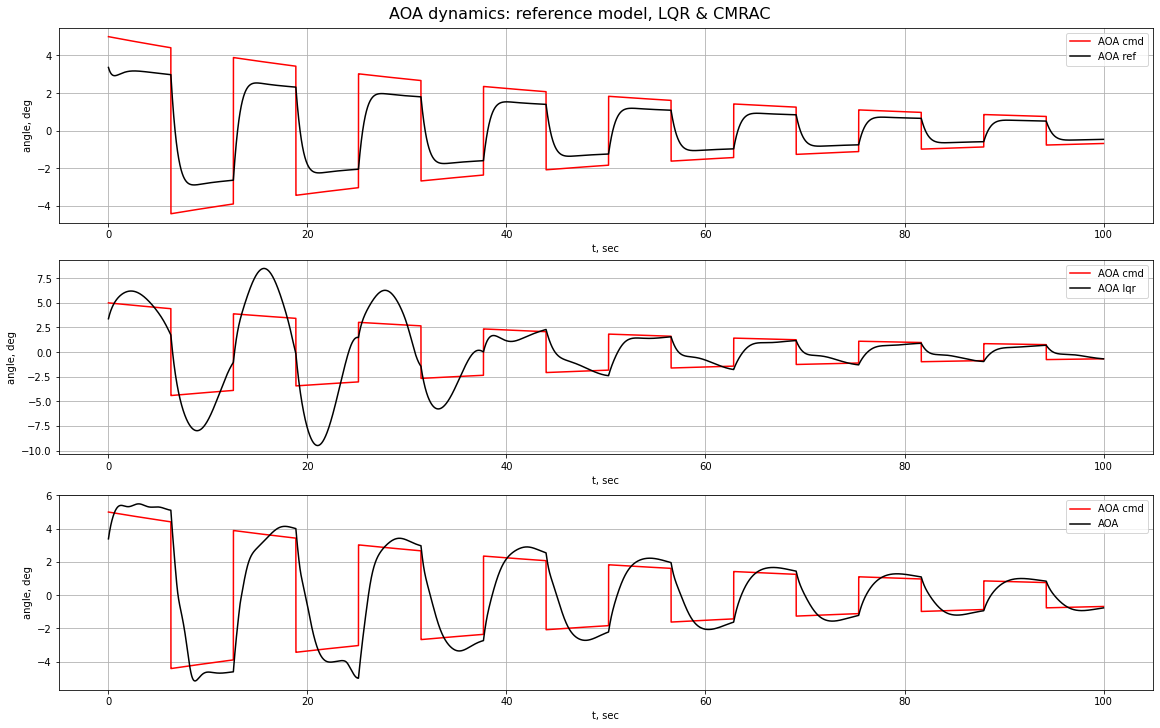

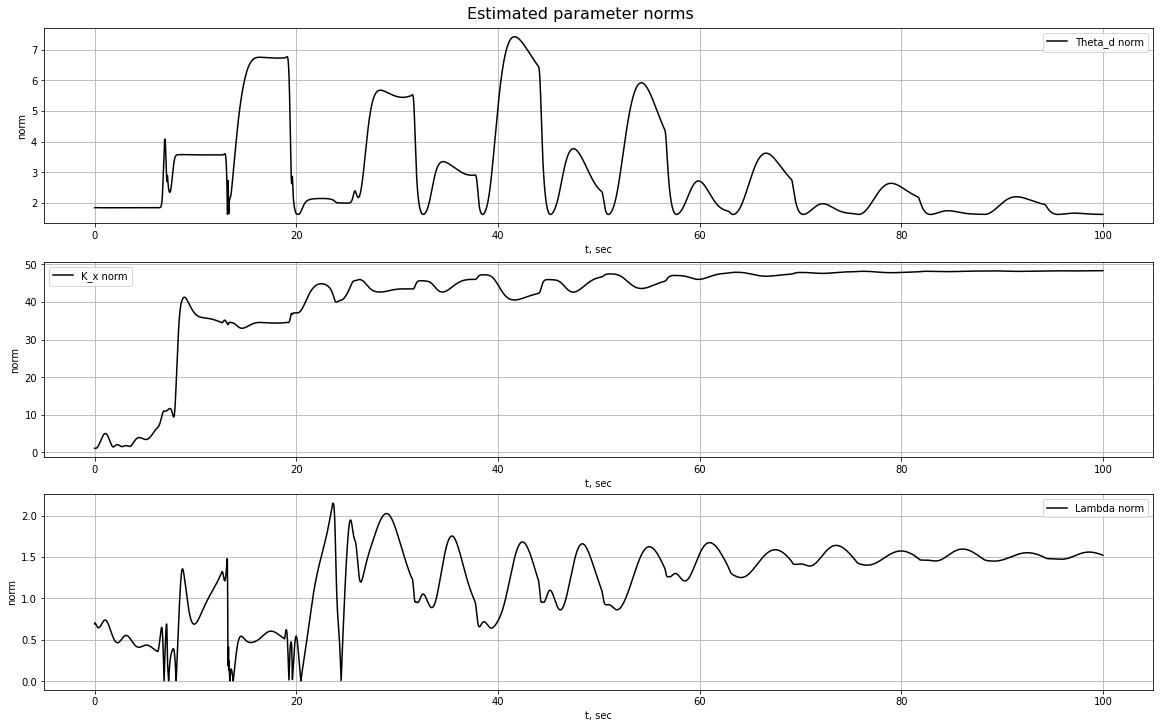

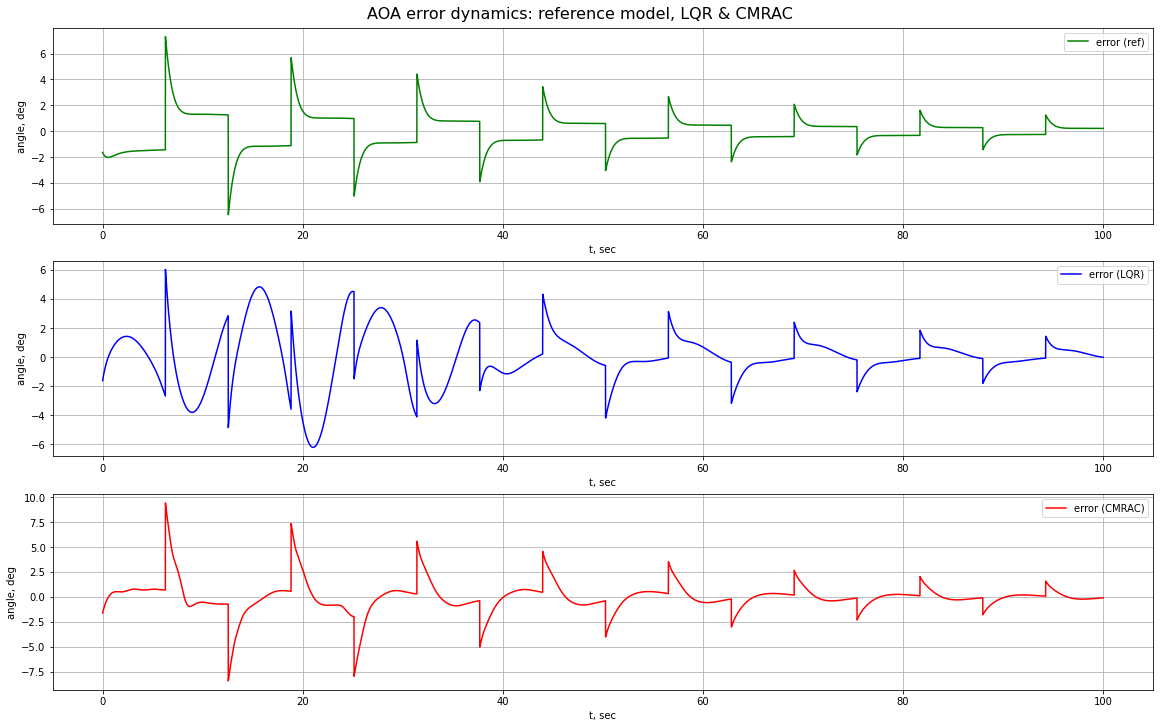

In [5]:
def reference_input(t : np.ndarray, ampl : float = 5., dec : float = 1e-3)->np.ndarray:
    
    #decaying square wave with amplitude of 5 degrees
    
    a = dec / 100
    b = dec
    
    return ampl*np.exp(-a*t)*square(t/b)

def reference_model_step(x_ref : np.ndarray, 
                         r: float,
                         A_ref : np.ndarray, 
                         B_c : np.ndarray)->np.ndarray:
    
    #x should have dimensions (3,1)
    #r should be float
    
    
    return (A_ref.T @ x_ref + B_c * r)


def regressor(alpha : float, centers : np.ndarray, sigma : float, data_type = np.float64)->np.ndarray:
    
    #function returning regressor vector, uncertainty is nonzero only for second input (alpha)
    #chosen arbitrarily (but somewhat resembles the original), because the exact formula is not provided
    
    result = [np.exp(-0.5*((alpha - c_i)/sigma) ** 2) for c_i in centers]
    
    return np.asarray(result).astype(data_type)
    

def d(alpha : float, center : float, sigma: float)->np.ndarray:
    
    # uncertainty vector for alpha
    
    return np.exp(-0.5*((alpha - center)/sigma) ** 2, dtype=np.float32)

def plant_step(x : np.ndarray, 
               u : float,
               r : float,
               A_bl : np.ndarray,
               B : np.ndarray,
               B_c : np.ndarray,
               Lambda : float,
               K_pert : np.ndarray,
               d : float,
              )->np.ndarray:
    
    A_p = A_bl[:] + Lambda * B[:] @ K_pert[:].T
    
    return (A_p[:] @ x[:] + Lambda * (u+d) * B[:] + B_c[:] * r)

def K_PAA(Gamma_x : np.ndarray,
          x_p : np.ndarray,
          e : np.ndarray,
          P_ref : np.ndarray,
          B : np.ndarray,
          e_Y : float,
          gamma_c : float,
          x_f : np.ndarray,
         )->np.ndarray:
    return -(Gamma_x[:] @ x_p[:] @ e.T[:] @ P_ref[:] @ B[:] - e_Y * gamma_c * Gamma_x[:] @ x_f[:])

def Lambda_PAA(Gamma_lambda : float,
               gamma_c : float,
               e_Y : float,
               u_f : float,
               K_hat : np.ndarray,
               x_f : np.ndarray,
               Theta_hat : np.ndarray,
               Phi_d_f : np.ndarray,
              )->float:
    
    return -Gamma_lambda * gamma_c * e_Y * (u_f - K_hat.T[:] @ x_f[:] + Theta_hat.T[:] @ Phi_d_f[:])

def Theta_PAA(Gamma_theta : float,
               Phi_d : np.ndarray,
               e : np.ndarray,
               P_ref : np.ndarray,
               B : np.ndarray,
               e_Y : float,
               gamma_c : float,
               Phi_d_f : np.ndarray,
              )->np.ndarray:
    
    return Gamma_theta * (Phi_d[:] @ e.T[:] @ P_ref[:] @ B[:] - e_Y * gamma_c * Phi_d_f[:])

def LPF(C : float, x : np.ndarray, x_f : np.ndarray)->np.ndarray:
    
    return C * (x[:] - x_f[:])

def estimation_error(K_hat : np.ndarray, 
                     Theta_hat : np.ndarray, 
                     Lambda : float, 
                     Lambda_hat : float, 
                     x_f : np.ndarray, 
                     Phi_d_f : np.ndarray, 
                     u_f : float, 
                     d_alpha : float):
    
    Theta = np.concatenate((K_hat[:],Theta_hat[:]),axis=0)
    Phi_f = np.concatenate((-x_f[:], Phi_d_f[:]),axis=0)
    
    e_Y = Lambda * (Theta[:].T @ Phi_f[:] - d_alpha)
    e_Y += (Lambda_hat - Lambda) * (Theta[:].T @ Phi_f[:] + u_f)
    
    return e_Y


data_type = np.float64

dt = 1e-2 #integration step
steps = 1e4 #total number of steps

#reference input parameters
dec = 2
ampl = (5 * np.pi / 180) #conversion into radians: VERY IMPORTANT!

# reference model parameters

A_bl = np.asarray([[0,1,0],[0,-1.0189,0.9051],[0,0.8223,-1.0774]], dtype=data_type)
B = np.asarray([0,-0.0022,-0.1756], dtype=data_type).reshape(-1,1)
K_xbl = np.asarray([10,10.8786,6.0589], dtype=data_type).reshape(-1,1)

A_ref = A_bl + B @ K_xbl.T

B_c = np.asarray([0,1,0], dtype=data_type).reshape(-1,1) 
#paper has [-1,0,0], but reference model dynamics are incorrect with that choice of B_c
#this form was found empirically

N = A_ref.shape[-1] #dimensionality of the extended model

# plant parameters
centers = np.arange(-10,11,2, dtype=data_type) #regressor vector centers
sigma = 0.0233
d_center = 2 * np.pi / 180

n_regressors = len(centers)

K_pert = np.asarray([0,-4.6839,-9.8197], dtype=data_type).reshape(-1,1)

Lambda = 0.5

# update law parameters

Gamma_x = np.diag(np.asarray([1, 400, 400], dtype=data_type))

Gamma_thetta = 20
Gamma_lambda = 8
gamma_c = 4

lambda_f = 10

#solve Lyapunov equation for P_ref given Q_ref

Q_ref = -1*np.diag(np.asarray([0.1, 1, 800], dtype=data_type))
P_ref = solve_eq(A_ref.T, Q_ref)

# reference model initial conditions
x_ref = ampl * np.random.rand(N).reshape(-1,1).astype(data_type)

#LQR plant initial conditions
x_lqr = x_ref[:]
e_I_lqr = 0 #initial integrated error value for LQR controller

#initial estimator parameter values
Theta_hat = np.random.rand(n_regressors).reshape(-1,1).astype(data_type)

K_hat = np.random.rand(N).reshape(-1,1).astype(data_type)

Lambda_hat = np.random.rand()


#CMRAC plant initial conditions
x_p = x_ref[:]
e_I = 0 #initial integrated error value for CMRAC controller
Phi_d = regressor(x_p[1], centers, sigma) #initial regressor value
u = (K_xbl.T[:] + K_hat.T[:]) @ x_p[:] - Theta_hat.T[:] @ Phi_d[:] #initial control input value

#initial conditions for stable filter
x_f = x_ref[:]
Phi_d_f = Phi_d[:] #initial filtered  regressor value
u_f = u  #initial filtered u value

e_Y = 0

# data containers

true_alpha = []
ref_alpha = []
lqr_alpha = []
cmrac_alpha = []

Theta_norm = []
K_norm = []
Lambda_norm = []

e1 = []
e2 = []
e3 = []

for t in tqdm(np.arange(dt, steps*dt, dt)):
    
    ###MODEL REFERENCE STEP
     
    r = reference_input(t, ampl = ampl, dec = dec)
    
    x_ref = x_ref[:] + dt * reference_model_step(x_ref[:], r, A_ref[:], B_c[:])
    
    x_ref[0] = 0
    
    e1.append(x_ref[1] - r)
    
    ###LQR CONTROLLER STEP
    
    u_lqr = K_xbl.T[:] @ x_lqr[:] #LQR control signal
    
    d_alpha_lqr = d(x_lqr[1], d_center, sigma)
    
    x_lqr = x_lqr[:] + dt * plant_step(x_lqr[:], u_lqr, r, A_bl[:], B[:], B_c[:], Lambda, K_pert[:], d_alpha_lqr)
    
    e_I_lqr = e_I_lqr + dt * (x_lqr[1] - r) #update integrated error
    x_lqr[0] = e_I_lqr
    
    e2.append(x_lqr[1] - r)
    
    ###CMRAC CONTROLLER STEP
    
    #1) calculate new regressor values
    d_alpha = d(x_p[1], d_center, sigma) #d(alpha)
    Phi_d = regressor(x_p[1], centers, sigma)
    
    #2) calculate control input
    u =  (K_xbl.T[:] + K_hat.T[:]) @ x_p[:] - Theta_hat.T[:] @ Phi_d[:]
    
    
    #3) perform a CMRAC plant step
    x_p = x_p[:] + dt * plant_step(x_p[:], u, r, A_bl[:], B[:], B_c[:], Lambda, K_pert[:], d_alpha)
    
    
    #4) calculate filtered values
    x_f = x_f[:] + dt * LPF(lambda_f, x_p[:], x_f[:])
    u_f = u_f[:] + dt * LPF(lambda_f, u[:], u_f[:])
    Phi_d_f = Phi_d_f[:] + dt * LPF(lambda_f, Phi_d[:], Phi_d_f[:])

    
    #5) calculate errors
    e_I = e_I + dt * (x_p[1] - r) #integrated error
    x_p[0] = e_I
    e = x_p[:] - x_ref[:] #tracking error
    
    e3.append(x_p[1] - r)
    
    ##calculate parameter estimation error
    
    e_Y = estimation_error(K_hat[:], Theta_hat[:], Lambda, Lambda_hat, x_f[:], Phi_d_f[:], u_f, d_alpha)
    
    
    #6) perfrom update law 
    
    #calculate Lambda_lat
    #Lambda_hat goes first because it uses K_hat and Theta_hat from the previous time-step
    Lambda_hat = Lambda_hat + dt * Lambda_PAA(Gamma_lambda, gamma_c, e_Y, u_f, K_hat[:], x_f[:], Theta_hat[:], Phi_d_f[:])
    
    #calculate K_hat
    K_hat = K_hat[:] + dt * K_PAA(Gamma_x[:], x_p[:], e[:], P_ref[:], B[:], e_Y, gamma_c, x_f[:])
    
    #calculate Theta_hat
    Theta_hat = Theta_hat[:] + dt * Theta_PAA(Gamma_thetta, Phi_d[:], e[:], P_ref[:], B[:], e_Y, gamma_c, Phi_d_f[:])
    
    true_alpha.append(r)
    ref_alpha.append(x_ref[1])
    lqr_alpha.append(x_lqr[1])
    cmrac_alpha.append(x_p[1])
    
    Theta_norm.append(np.linalg.norm(Theta_hat))
    K_norm.append(np.linalg.norm(K_hat))
    Lambda_norm.append(np.linalg.norm(Lambda_hat))
    
fig = plt.figure(figsize=(16,10), constrained_layout=True)

rows = 3
columns = 1
ax = []
for i in range(1, columns*rows +1):
    ax.append(fig.add_subplot(rows, columns, i))
    
ax[0].plot(np.arange(dt, steps*dt, dt), np.asarray(true_alpha) / np.pi * 180, label='AOA cmd', color='red')
ax[0].plot(np.arange(dt, steps*dt, dt), np.asarray(ref_alpha) / np.pi * 180, label='AOA ref', color='black')

ax[1].plot(np.arange(dt, steps*dt, dt), np.asarray(true_alpha) / np.pi * 180, label='AOA cmd', color='red')
ax[1].plot(np.arange(dt, steps*dt, dt), np.asarray(lqr_alpha) / np.pi * 180, label='AOA lqr', color='black')

ax[2].plot(np.arange(dt, steps*dt, dt), np.asarray(true_alpha) / np.pi * 180, label='AOA cmd', color='red')
ax[2].plot(np.arange(dt, steps*dt, dt), np.asarray(cmrac_alpha) / np.pi * 180, label='AOA', color='black')

for a in ax:
    a.legend()
    a.set_xlabel("t, sec")
    a.set_ylabel("angle, deg")
    a.grid()    

fig.suptitle("AOA dynamics: reference model, LQR & CMRAC", fontsize=16)


fig1 = plt.figure(figsize=(16,10), constrained_layout=True)

rows = 3
columns = 1
ax1 = []
for i in range(1, columns*rows +1):
    ax1.append(fig1.add_subplot(rows, columns, i))
    
ax1[0].plot(np.arange(dt, steps*dt, dt), Theta_norm, label='Theta_d norm', color='black')
ax1[1].plot(np.arange(dt, steps*dt, dt), K_norm, label='K_x norm', color='black')
ax1[2].plot(np.arange(dt, steps*dt, dt), Lambda_norm, label='Lambda norm', color='black')


for a in ax1:
    a.legend()
    a.set_xlabel("t, sec")
    a.set_ylabel("norm")
    a.grid()

fig1.suptitle("Estimated parameter norms", fontsize=16)

print("Reference model MSE is {}".format(np.round(MSE(true_alpha, ref_alpha, squared=False),3)))
print("LQR model MSE is {}".format(np.round(MSE(true_alpha, lqr_alpha, squared=False),3)))
print("CMRAC model MSE is {}".format(np.round(MSE(true_alpha, cmrac_alpha, squared=False),3)))


fig2 = plt.figure(figsize=(16,10), constrained_layout=True)

rows = 3
columns = 1
ax2 = []
for i in range(1, columns*rows +1):
    ax2.append(fig2.add_subplot(rows, columns, i))
    
ax2[0].plot(np.arange(dt, steps*dt, dt), np.asarray(e1) / np.pi * 180, label='error (ref)', color='green')
ax2[1].plot(np.arange(dt, steps*dt, dt), np.asarray(e2) / np.pi * 180, label='error (LQR)', color='blue')
ax2[2].plot(np.arange(dt, steps*dt, dt), np.asarray(e3) / np.pi * 180, label='error (CMRAC)', color='red')

for a in ax2:
    a.legend()
    a.set_xlabel("t, sec")
    a.set_ylabel("angle, deg")
    a.grid()   

fig2.suptitle("AOA error dynamics: reference model, LQR & CMRAC", fontsize=16)